### Importando librerias y funciones

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime, timedelta, date
import pandas_datareader.data as web

### Cargando la base de datos

In [137]:
training_set = pd.read_csv('CSGN.SW.csv', sep=',')
training_set['Date']
training_set['Date']=pd.to_datetime(training_set['Date'], format='%Y-%m-%d')


### Localizando valores faltantes

In [138]:
training_set.isna().sum()

Date           0
Open         297
High         297
Low          297
Close        297
Adj Close    297
Volume       297
dtype: int64

### Reemplazando los valores faltantes por la mediana de cada variable

In [139]:
mediana_open=training_set['Open'].median()
mediana_open
training_set['Open'].fillna(value=mediana_open, inplace=True)

In [140]:
mediana_high=training_set['High'].median()
mediana_high
training_set['High'].fillna(value=mediana_high, inplace=True)

In [141]:
mediana_low=training_set['Low'].median()
mediana_low
training_set['Low'].fillna(value=mediana_low, inplace=True)

In [142]:
mediana_close=training_set['Close'].median()
mediana_close
training_set['Close'].fillna(value=mediana_close, inplace=True)

In [143]:
mediana_adj=training_set['Adj Close'].median()
mediana_adj
training_set['Adj Close'].fillna(value=mediana_adj, inplace=True)

In [144]:
mediana_volumen=training_set['Volume'].median()
mediana_volumen
training_set['Volume'].fillna(value=mediana_volumen, inplace=True)

### Ubicando outliers

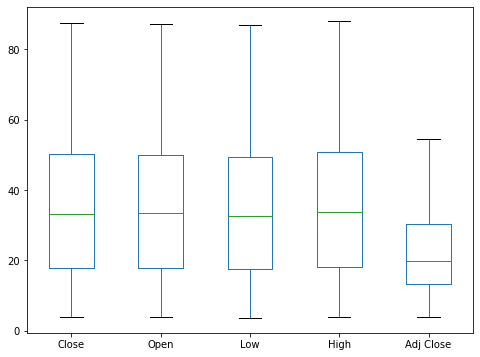

In [145]:
training_set.boxplot(column=['Close', 'Open', 'Low', 'High', 'Adj Close'], figsize=(8,6), grid=False)

### Sin presencia de valores atipicos

### Definiendo la variable 'date' como fecha y reorganizando la serie de forma ascendete

In [146]:
training_set['Date']=pd.to_datetime(training_set['Date'])
training_set= training_set.sort_values(by="Date",ascending=True)

### Filtrando la variable 'Date' y creando nuevo data frame con una serie fragmentada, a partir del año 2016.

In [147]:
training_set=training_set[(training_set.Date >= '31-12-2015') & (training_set.Date <= '10-12-2022')]

In [148]:
training_set.head()

,Date,Open,High,Low,Close,Adj Close,Volume
5317,2016-01-04,20.687891,20.707190,20.051044,20.398415,15.951595,5677772.0
5318,2016-01-05,20.543154,20.697540,20.253677,20.562452,16.079870,4159650.0
5319,2016-01-06,20.543154,20.629995,20.253677,20.350168,15.913866,5486576.0
5320,2016-01-07,19.809814,19.877357,19.279108,19.751919,15.446033,9343067.0
5321,2016-01-08,19.703672,19.790516,19.028229,19.028229,14.880106,7963050.0


### Graficando la serie correspondiente a los datos bursátiles de credit swiss

<Figure size 432x288 with 0 Axes>

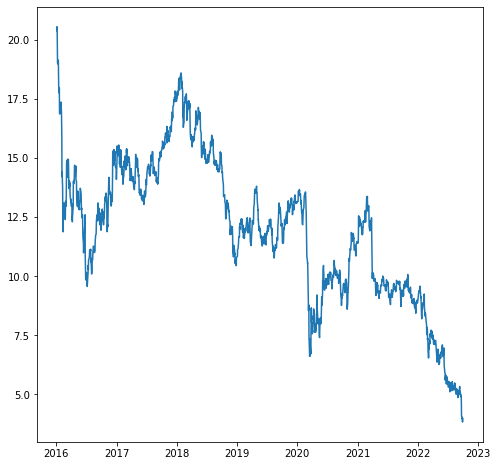

In [149]:
plt.suptitle('Datos bursátiles Credit Suisse')
figure(figsize=(8,8))
plt.plot('Date', 'Close', data=training_set)
plt.show()

### Se aprecia una tendencia a la baja, con algunas fluctuaciones en los últimos dos años y con un descenso paulatino entre la segunda mitad del 2020 hasta la fecha.

In [150]:
training_set = training_set.iloc[:,1:2].values


### Particionando la data en muestra test y muestra train

In [151]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set) 

seq_length = 30  
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.75)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Definiendo el modelo de red neuronal LSTM

In [152]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Definiendo los hiperparámetros y graficando la función loss Vs Epoch

In [153]:

num_epochs = 85
input_size = 1
hidden_size = 5
num_layers = 1

num_classes = 1
learning_rate = 0.01


lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
Loss=[]
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    Loss.append(loss.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0 and epoch !=0: 
      print("Epoch ", epoch, "loss ", loss.item())

Epoch  10 loss  0.008817553520202637
Epoch  20 loss  0.002537403255701065
Epoch  30 loss  0.0012382150162011385
Epoch  40 loss  0.0006839928100816905
Epoch  50 loss  0.0005727182142436504
Epoch  60 loss  0.0005390987498685718
Epoch  70 loss  0.0005242846673354506
Epoch  80 loss  0.0005096090026199818


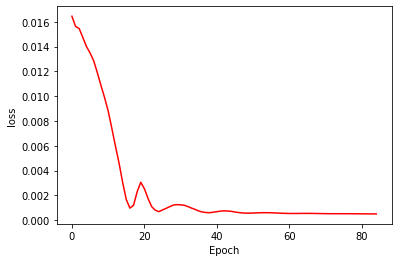

In [154]:
plt.plot(Loss, label="loss function", color='red')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

### Estableciendo las predicciones y comparando estas con los valores reales de la serie, lo que se puede visualizar el en grafico

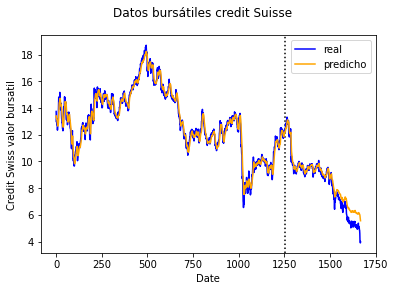

In [155]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy() 
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='black', linestyle=':')
plt.plot(dataY_plot, color='blue', label='real')
plt.ylabel('Credit Swiss valor bursatil')
plt.xlabel('Date')
plt.plot(data_predict, color='orange', label='predicho')
plt.legend(loc='upper right')
plt.suptitle('Datos bursátiles credit Suisse')
plt.savefig('datos bursátiles credit Suisse.png')
plt.show()


In [156]:
mean_squared_error(data_predict, dataY_plot)

0.18092974

### Calculando el valor del error cuadrático medio para el modelo de deep learning. Según el valor obtenido, el modelo es muy preciso al momento de estimar, el valor de 0.35 indica que existe poca diferencia entre los valores reales y los valores predichos, lo que indica un gran ajuste en las predicciones.

In [157]:
mean_absolute_error(data_predict, dataY_plot)

0.3118058

### El valor del MAE (0.42) confirma la poca diferencia absoluta entre los valores reales Vs los valores predichos, por lo que el modelo aplicado presenta un buen ajuste a los datos.